# Topic Modeling and Topic Sentiments

# 0. Introduction

This study project grew out of one assignment that I received when applying to one of Data Engineering position. My goal was to create end-to-end solution for extracting topics from the large corpus of texts that also have a date attribute, like news, scientific articles, etc. I will also look at evolution of topics in given corpus and explore the ways to extract the topic related sentiment for given text. I am not going into deep analysis of concrete dataset, but rather demonstrate some possible tools to tackle the problem. 

Main difference of Topic Modeling (TM) and Topic Classification is that we dont have labelled data, so it is essentially non-supervised learning problem. The way people approach TM problem is to represent every topic as some distribution over the words in a corpus dictionary. Thus "reverting" topic - words relationship we can be find text over topics distribution. There are two classical approach to learn these 2 distributions: Nonnegative Matrix Factorization (NMF) and Latent Dirichlet Allocation  (LDA). The former is known to converge faster but gives less accurate results comparing to the latter. Both methods have implementations supporting online training which is important when you try to process very large corpus and have a memory constraint. Below I present a study based on most popular python library dedicated to TM tasks - *gensim* and I focus only on LDA approach and its dynamic extension like DTM (Dynamic Topic Models suggested by by Blei and Lafferty). Other alternative for LDA implementation are spark MLLIb (in python or scala) which allows parallelization and potentially can converge faster. 

Every section starts with a subsection showing helper functions used below in the processing and result analysis subsections. 

In my analysis I am using a custom data collection of around 180K news articles spanning period of sevral years  located on my google drive: https://drive.google.com/open?id=1bAozH8vBL2bfAmW-qwDPsIAoHeX0CrQa. I am also created smaller rnadom subsamples of original set with 20k (https://drive.google.com/open?id=1lWGZlTw07aRGO54ppCIEGOhe6xbLZNUe), 5K (https://drive.google.com/open?id=1IlI0AOwFPgNhtS9EDOvcDIWXy48Zvlpm) and 1K (https://drive.google.com/open?id=1IvX5DqOjmFIpn8IU6aDVWuGei0d6YCWv) news items. The data is stored as SQLLite database file within a single table named *news*. All trained models (BOW representations, LDA, etc.) are stored in https://drive.google.com/open?id=1GPVM5QBv2Q3mIfEgY4Iiziz87GBfMqxd. 

I am using python 3.7 environment with all the imports defined in requirements.txt for pip installation (pip install -r requirements.txt) or in environment.yml for conda (conda env create -f environment.yml).


# 1. Data ingestion helper functions

In below cell *data_iterator* function is a data generator that extracts and feed data from SQLLite database file using provided sql and *preprocess_etl* ETL transformation importing from one SQLLite file, transforming and writing to another SQLLite file. Last function *create_sample* was used for generating random sub-samples from original data set.

In [444]:
import nltk

def load_nltk_resources():
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    #try:
    #    nltk.data.find('corpora/wordnet')
    #except LookupError:
    #    nltk.download('wordnet')
    try:
        nltk.data.find('tokenizers/punkt/english.pickle')
    except LookupError:
        nltk.download('punkt')
    nltk.download('vader_lexicon') 
load_nltk_resources()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\zmiv001\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [445]:
import sqlite3
import os
import json
import re

'''
 Iterator function returning iterator of the rows from sqlite DB as results of executing provided SQL query.
 It is used everywhere below
'''
def data_iterator(dbfile, select_sql, transformer=None):
    conn = sqlite3.connect(dbfile)
    cur = conn.cursor()
    for row in cur.execute(select_sql):
        if transformer is not None:
            try:
                yield transformer(row)
            except:
                conn.close
                raise
        else:
            yield [row]
    conn.close       
'''
 Small ETL function providing a way quickly load data from one sqlite DB, transform and save to another sqllite DB.
 It uses batch insert to accelerate insertion

'''    
def preprocess_etl(source_iterator, dbfile_dest, table_dest, table_struct, batch_size, printout_size=1000):
    
    if os.path.isfile(dbfile_dest):
        os.remove(dbfile_dest)
        print("Deleted existing file {}.".format(dbfile_dest))
    conn = sqlite3.connect(dbfile_dest)
    cur = conn.cursor()
    cur.execute("create table if not exists {} {}".format(table_dest, table_struct))
       
    def insert_batch(batch_list,table, conn, cur):
        cur.execute("BEGIN TRANSACTION")
        if(len(batch_list) < 1):
            return
        placeholders = ','.join(['?']*len(batch_list[0]))
        for row in batch_list:
            insert_sql = "insert into {} values ({})".format(table,placeholders)
            cur.execute(insert_sql,row)
        conn.commit()  
  
    batch = []
    for c, row in enumerate(source_iterator, start=1):
        batch.extend(row)
        if c % batch_size == 0:
            insert_batch(batch, table_dest, conn, cur)
            batch = []
        if c % printout_size == 0:
            print("Processed {} rows".format(c))
    insert_batch(batch, table_dest, conn, cur)
    conn.close()
    
'''
Extract data from DB in list format
'''
def get_list(source_file,sql):
    val = [s for s in data_iterator(source_file, sql, transformer=lambda x: x[0])]
    return val

'''
Extract single value from DB as provided by SQL query 
'''
def get_single_value(source_file, sql):
    return get_list(source_file,sql)[0]

'''
    Create random subsample of given data from sqlite db and save in differnt db file
    Input:
        source_db -- DB file with source data
        sample_db -- DB file with target data
        sample_size  -- size of sample
'''
def create_sample(source_db,sample_db, sample_size):
    sql = "select id, title, content, date from news where id in (select id from news order by random() limit {})".format(sample_size)
    batch_size=5000
    iterator = data_iterator(source_db, sql)
    preprocess_etl(iterator, sample_db, 'news', \
                   "(id integer, title text, content text, date integer)",\
                   batch_size, printout_size=5000)
    

# 2. Preprocessing the data

To build LDA model we need to create a bag of words (BOW) representation of the original news corpus. In order to construct efficient BOW representation in a context of TM problem we have to do several preprocessing steps. Namely we will incorporate lemmatization and include most frequent bigrams. We will 3 steps of preprocessing: tokenization, add bigrams and lemmatization.

## 2.1. Helper functions

Next cell contains all the helper function for above mentioned prepprocessing steps.

In [410]:
from gensim.utils import simple_preprocess
import sqlite3
import nltk
from nltk.corpus import stopwords
import re
import json
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import lemmatize
from gensim import corpora


def get_ext_stopwords():
        return set(stopwords.words('english')) | set(['would', 'could'])

def tokenize(text):
    return [w for w in simple_preprocess(text) if w not in get_ext_stopwords()] 


def create_tokenized_data(dbfile_source, dbfile_dest):
    
   
    batch_size=5000
    sql = '''select id, title, content, date from news order by date '''
   
    def transform_tokenize(row):
        title_text = row[1] + ' ' + row[2]
        tokens = tokenize(title_text)
        return [(row[0],json.dumps(tokens),row[3])]
    
    source_iterator = data_iterator(dbfile_source,sql, transformer = transform_tokenize)
    preprocess_etl(source_iterator, dbfile_dest, 'news', \
                   "(id integer, tokens text, date integer)",\
                   batch_size, printout_size=5000)
    print("Tokenized data is saved")



def add_bigrams(tokens_list):
    bigram_model = Phraser(Phrases(tokens_list, min_count=1, threshold = 1))
    return bigram_model[tokens_list]


def create_bigram_data(dbfile_source, dbfile_dest, bigram_min_count=5,bigram_threshold=1 ):
      
    batch_size=5000
    sql = 'select id, tokens, date from news order by date'
   
    def transform_load_tokens(row):
        return json.loads(row[1])
    
    iterator_source = data_iterator(dbfile_source,sql, transformer = transform_load_tokens)
    bigram_phr = Phrases(iterator_source, min_count=bigram_min_count, threshold = bigram_threshold)
    bigram_model = Phraser(bigram_phr)
    print("Bigram model is created")
    
    def transform_add_birgam(row):
        return [(row[0], json.dumps(bigram_model[json.loads(row[1])]), row[2])]
    iterator_add_bigrams = data_iterator(dbfile_source, sql, transformer = transform_add_birgam)
    
    preprocess_etl(iterator_add_bigrams, dbfile_dest, 'news', \
                   "(id integer, tokens text, date integer)",\
                   batch_size, printout_size=5000)
    print("Tokenized data with bigrams is saved")


def create_lemmatized_data(tokens_source_db,lemmatized_db, batch_size=100):
    sql = 'select id, tokens, date from news'
    #excluded_words_set = set(excluded_words) if excluded_words is not None else None
    def lemmatize_tokens(tokens):
        lemmatized = []
        for token in tokens:
            try:
                if token is not None:
                    lemmatized.extend(lemmatize(token))
            except Exception as e: 
                print("Problem with lemmatizing token = "+str(token), e)
            
        out = [word.split(b'/')[0].decode('utf-8') for word in lemmatized]
        return out
    
    def transform_lemmatize(row):
       
        out = [(row[0], json.dumps(lemmatize_tokens(json.loads(row[1]))),row[2])]
        return out
        
    iterator_lemmatized = data_iterator(tokens_source_db, sql, transformer = transform_lemmatize)
    preprocess_etl(iterator_lemmatized, lemmatized_db, 'news', \
                   "(id integer, tokens text, date integer)",\
                   batch_size, printout_size=1000)
    print("Lemmatized data is saved")

    
def preprocess_data(source_db,tokenized_db,bigram_db=None,lemmatized_bd=None):
    create_tokenized_data(source_db,tokenized_db)
    if bigram_db is not None:
        create_bigram_data(tokenized_db,bigram_db)
    if lemmatized_bd is not None:
        create_lemmatized_data(bigram_db,lemmatized_bd)

## 2.2. Create sub samples

In below cell I show (as commented code) how to I have created subsamples from original 180K subset of news. 

In [2]:
#create_sample('db/news_cleaned.db', 'db/news_cleaned_5k.db', 5000)
#create_sample('db/news_cleaned.db', 'db/news_cleaned_20k.db', 20000)
#create_sample('db/news_cleaned.db', 'db/news_cleaned_1k.db', 1000)

## 2.3. Preprocess pipeline for cleaned news texts

The function *preprocess_data* chains 3 preprocess operations: tokenization, adding brigram tokens and lemmatization. Each step is saved in corresponding file presented in the arguments. I demonstrate the output of running of preprocessing for 5K sample. Where was possible in the analysis below I was 20K sample (shown in commented line, in fact I ran this steps outside of this notebook), also I did preprocessing for 1K sample as well (shown in commented line).

In [27]:
preprocess_data('db/news_cleaned_5k.db', 'db/news_tokens_5k.db','db/news_bigram_5k.db', 'db/news_lemma_5k.db')

Deleted existing file news_tokens_5k.db.
Processed 5000 rows
Tokenized data is saved
Bigram model is created
Deleted existing file news_bigram_5k.db.
Processed 5000 rows
Tokenized data with bigrams is saved
Deleted existing file news_lemma_5k.db.
Problem with lemmatizing token = one generator raised StopIteration
Problem with lemmatizing token = part generator raised StopIteration
Problem with lemmatizing token = loves generator raised StopIteration
Processed 1000 rows
Processed 2000 rows
Processed 3000 rows
Processed 4000 rows
Processed 5000 rows
Lemmatized data is saved


In [446]:
#preprocess_data('db/news_cleaned_20k.db', 'db/news_tokens_20k.db','db/news_bigram_20k.db', 'db/news_lemma_20k.db')
#preprocess_data('db/news_cleaned_1k.db', 'db/news_tokens_1k.db','db/news_bigram_1k.db', 'db/news_lemma_1k.db')

# 3. Train LDA and show results

## 3.1. Helper functions

In [416]:
from gensim import corpora
import json
from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore

'''
 Creates and saves to file BOW corpus and dictionary.
 It first build the dictionary, then trims it and then creates a BOW corpus and saves dictionary and corpus 
 Inputs:
    tokens_source_db -- sqlite file with tokenized news contents
    corpus_file      -- file path where BOW corpus will be saved
    dict_file        -- file path where dictionary file will be saved default 'bow_dict.dic'
    filter_dict_below -- minimum doc frequency filter for dictionary words
    filter_dict_above -- maximum doc frenquency expressed as a maximum ratio of document where this words is present
    filter_dict_max   -- maximum number of word in a dictionary

'''
def create_bow_corpus(tokens_source_db, corpus_file, dict_file='model/bow_dict.dic', \
                      filter_dict_below=10, filter_dict_above=0.5, filter_dict_max=100000):
    def bowCorpusGenerator(source_iterator, dictionary, printout_chunk = 10000):
        print("BOW corpus building started...")
        for n, tokens in enumerate(source_iterator,start=1):
            doc_bow = dictionary.doc2bow(tokens, allow_update=False)
            if(n % printout_chunk == 0):
                print("Processed {} documents".format(n))
            yield doc_bow
    sql = 'select tokens from news'
    tokenized_source_iterator = data_iterator(tokens_source_db, sql,transformer = lambda x: json.loads(x[0]))
    
    print("Building dictionary ... ")
    dictionary = corpora.Dictionary(tokenized_source_iterator)
    print("Total dictionary: "+ str(dictionary))
    dictionary.filter_extremes(no_below=filter_dict_below, no_above=filter_dict_above, keep_n=filter_dict_max)
    print("Trimmed dictionary: "+ str(dictionary))

    tokenized_source_iterator = data_iterator(tokens_source_db, sql,transformer = lambda x: json.loads(x[0]))
    bow_corpus = bowCorpusGenerator(tokenized_source_iterator, dictionary)
    corpora.MmCorpus.serialize(corpus_file,bow_corpus)
    print("BOW corpus saved...")
    dictionary.save(dict_file)

'''
 Trains LDA model for fixed number of topic, using BOW corpus abd dictionary. Trained model is saved
 Inputs:
    num_topics -- number of topic used for training
    corpus      -- BOW corpus
    id2word_dict  -- dictionary mapping word ID to word itself
    to_save     -- save trained LDA model is this flag is true
    model_file  -- file path to save LDA model
    use_multicore -- if true utilize parallelized version of LdaModel - LdaMulticore
    the rest of parameters are training parameter used in LdaModel or LdaMulticore initializers:
      iterations=50, 
      passes=1, 
      chunksize=100,
      alpha='asymmetric'
 
'''

def train_lda(num_topics, corpus, id2word_dict, to_save=True, model_file='lda.model', \
              iterations=50, passes=1, chunksize=100, alpha='asymmetric', use_multicore=True):
    id2token = {id: token for (token, id) in id2word_dict.token2id.items()}
    lda = None
    if use_multicore:
        lda = LdaMulticore(corpus=corpus, \
                           id2word=id2token, \
                           num_topics=num_topics, \
                           chunksize=chunksize, \
                           alpha=alpha, \
                           eta='auto', \
                           iterations=iterations, \
                           eval_every=None, \
                           passes=passes, \
                           per_word_topics=False)
    else:
        lda = LdaModel(corpus=corpus, \
                       id2word=id2token, \
                       num_topics=num_topics, \
                       chunksize=chunksize, \
                       alpha='auto', \
                       eta='auto', \
                       iterations=iterations, \
                       eval_every=None, \
                       passes=passes, \
                       per_word_topics=False)

    if to_save:
        lda.save(model_file)
    return lda


def train_lda_from_files(num_topics, corpus_file, dict_file, to_save=True, model_file='model/lda.model', \
                         iterations=50, passes=1, chunksize=100, alpha='asymmetric', use_multicore=True):
    id2word_dict = corpora.Dictionary.load(dict_file)
    corpus = corpora.MmCorpus(corpus_file)
    lda_mod = train_lda(num_topics, corpus, id2word_dict, to_save=to_save, model_file=model_file, \
                        iterations=iterations, passes=passes, chunksize=chunksize, alpha=alpha,
                        use_multicore=use_multicore)
    return lda_mod    


'''
   Create TDIDF corpus from BOW corpus, used only in experiments to see if performance is improved. 
''' 
from gensim.models.tfidfmodel import TfidfModel
def create_tfidf_corpus(bow_source_file,tfidf_corpus_file):
    
    corpus = corpora.MmCorpus(bow_source_file)
    print("Computing TFIDF model...")
    tfidf_corpus = TfidfModel(corpus, smartirs='ntc')
    corpora.MmCorpus.serialize(tfidf_corpus_file,tfidf_corpus[corpus])
    print("TFIDF corpus is saved...")

## 3.2 Create bag of word corpus and dictionary

Showing the output of the function create_bow_corpus using sample of 5K documents. It is creating and saving to file BOW corpus and dictionary object of type gensim.corpora.Dictionary. The output for 5K case shows that the dictionary trimming step allowed to reduce the initial dictionary of 74980 words to 39586 words. During trimming phase we remove very unfrequent words that appear in less than 3 documents (parameter filter_dict_below) and too frequent words (parameter filter_dict_above) appearing in more than 50% of the documents  

In [15]:
create_bow_corpus('db/news_lemma_5K.db','model/bow_corpus_5K.mm',dict_file='model/bow_dict_5K.dic',\
                 filter_dict_below=3, filter_dict_above=0.5)

Building dictionary ... 
Connection closed...
Total dictionary: Dictionary(74980 unique tokens: ['agreeable', 'beginning', 'black', 'blacken', 'build']...)
Trimmed dictionary: Dictionary(39586 unique tokens: ['agreeable', 'beginning', 'black', 'blacken', 'build']...)
BOW corpus building started...


C:\Anaconda3\envs\topics\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Connection closed...
BOW corpus saved...


## 3.3 Train LDA
 
I train LDA using gensim LdaModel implmentation. The function has an option of using parallelizable version of algorithm, but I wont be able to make it work on windows PC. Also all my attempts to train the LdaModel on my desktopcomputer on entire data set with 180K+ documents were not successful (computations are still continuing after 24 hours run ). Instead  I have used 5K and 20K random subsamples created and saved on previous steps.
Main reason for my choice of these implementations is that they both support online training without the need to load entire corpus to the memory. 
Other versions of LDA like wrapper to MALLET java library do not support corpus iterator and could not be used on large samples.
Below is the example of the call producing LDA model based on 5K sample.

In [32]:
lda_5k = train_lda_from_files(100, 'model/bow_corpus_5K.mm', 'model/bow_dict_5K.dic', to_save=True, model_file='model/lda_5k.model', \
                         iterations=100, passes=5, chunksize=100, alpha='auto', use_multicore=False)

C:\Anaconda3\envs\topics\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Anaconda3\envs\topics\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


## 3.4 Optimize model, meta parameter optmizations

There are several metaparameters to control in LDA model. The most important structure related parameter in gensim LdaModel is the number of topics. All the others related to individual training process optimisation: number of passes, alpha, number iterations for every epoch, chunksize. Below is function *find_optimal_model* that is finding optimal number of topics using coherence metrics implemented in  gensim.models.CoherenceModel class. All other training parameters are kept constant in such optimisation. 

In [411]:
from gensim.models import CoherenceModel
def find_optimal_model(corpus_file, texts_file_db, texts_table, text_sampling_size, dict_file, start_range, end_range, step, passes=1, iterations=10):
    optimal_model = None
    coherence_scores=dict()
    id2word_dict = corpora.Dictionary.load(dict_file)
    corpus = corpora.MmCorpus(corpus_file)
    texts = create_tokenized_sample(texts_file_db, texts_table, text_sampling_size)
    max_score = -1000000
    optimal_n = -1
    for n in range(start_range,end_range+1,step):
        print("Evaluating number of topics:" + str(n))
        lda = train_lda(n, corpus, id2word_dict, to_save=False,passes=passes,iterations=iterations)
        coh_score = CoherenceModel(model=lda, corpus = corpus, texts=texts, dictionary=id2word_dict, coherence='c_uci').get_coherence()
        print("Coherence score found:" + str(coh_score))
        coherence_scores[n]=coh_score
        if max_score < coh_score:
            max_score = coh_score
            optimal_model = lda
            optimal_n = n
    return (optimal_n, optimal_model, coherence_scores)

To observe reasonbly meaningfull results I had to use at least 5K subsample corpus. Since training LdaModel on 5K sample is quite long for 5K sample I only tried an optimization for the number of topics on 5K sample using relatively low values for number of passes and iterations parameters in LdaModel class initializer.
The results do not look right, most probably due to heavy underfitting. The optimization showed that this metric monotonically decayed with decrease of number of topics. Here the output of the optimization function find_optimal model (copied here from another cell). I did not have time to try more optimization and play with macroparameters

**(optimal_n, optimal_model, coh_score_map) = find_optimal_model('model/bow_corpus_5K.mm','db/news_lemma_5k.db', 'news_lemma',                    5000,'model/bow_dict_5K.dic', 20, 200, 20)**

**optimal_n, coh_score_map[optimal_n]**

Evaluating number of topics:20

Coherence score found:-0.08614063409120871

Evaluating number of topics:40

Coherence score found:-0.20516380901097656

Evaluating number of topics:60

Coherence score found:-0.37080399234071154

Evaluating number of topics:80

Coherence score found:-1.3022033957187396

Evaluating number of topics:100

Coherence score found:-1.0309514022815476

Evaluating number of topics:120

Coherence score found:-1.4911822264619128

Evaluating number of topics:140

Coherence score found:-2.07116989091888

Evaluating number of topics:160

Coherence score found:-2.635063020099355

Evaluating number of topics:180

Coherence score found:-4.42617713310207

Evaluating number of topics:200

Coherence score found:-4.744101956272372

(20, -0.08614063409120871)


## 3.5. Explore the results: topic model per document

Lets load earalier trained model based on 5K sample and print top topics

In [408]:
from gensim.models import LdaModel
lda_5k = LdaModel.load('model/lda_5k.model')
pprint(lda_5k.print_topics())

[(33,
  '0.001*"also" + 0.001*"include" + 0.001*"new" + 0.001*"first" + 0.001*"take" '
  '+ 0.001*"call" + 0.000*"lead" + 0.000*"see" + 0.000*"year" + '
  '0.000*"person"'),
 (48,
  '0.001*"also" + 0.001*"include" + 0.001*"new" + 0.001*"first" + 0.001*"take" '
  '+ 0.001*"call" + 0.000*"lead" + 0.000*"see" + 0.000*"year" + '
  '0.000*"person"'),
 (43,
  '0.147*"coastal" + 0.091*"make_way" + 0.057*"despite_fact" + 0.037*"neglect" '
  '+ 0.035*"close_family" + 0.026*"simpler" + 0.021*"nicer" + 0.005*"viii" + '
  '0.000*"also" + 0.000*"include"'),
 (59,
  '0.290*"protected" + 0.049*"password" + 0.031*"ideologically" + '
  '0.002*"please_enter" + 0.001*"also" + 0.000*"include" + 0.000*"new" + '
  '0.000*"first" + 0.000*"take" + 0.000*"call"'),
 (28,
  '0.288*"operator" + 0.070*"marshall" + 0.062*"oklahoma_city" + '
  '0.061*"footnote" + 0.043*"rivera" + 0.043*"false_alarm" + 0.029*"trustee" + '
  '0.000*"also" + 0.000*"include" + 0.000*"new"'),
 (25,
  '0.152*"cure" + 0.122*"diagnosis" + 0

### Loading trained LDA model on 20K sample

In [406]:
from gensim.models import LdaModel
lda_20k = LdaModel.load('model/lda_20k.model')

Show top 10 ranked words with their probability contribution to the topic 2. This example demonstrate

In [56]:
# show example of one topic with clear definition
lda_20k.show_topic(2,10)

[('russia', 0.22381641),
 ('russian', 0.17674187),
 ('moscow', 0.07307388),
 ('inquiry', 0.05556189),
 ('putin', 0.048029326),
 ('kremlin', 0.043010022),
 ('overseas', 0.028938517),
 ('reportedly', 0.023917112),
 ('vladimir_putin', 0.015426964),
 ('last_day', 0.014544908)]

Topic 1 is much more "mixed|

In [65]:
lda_20k.show_topic(1,10)

[('ms', 0.46108216),
 ('twitter', 0.10213757),
 ('tweet', 0.092536755),
 ('broadway', 0.047540527),
 ('account', 0.028417885),
 ('invitation', 0.020781582),
 ('eastern', 0.018590244),
 ('instruct', 0.016297676),
 ('local_news', 0.013000221),
 ('ambulance', 0.0097641535)]

In [129]:
# show top 5 topics with top 10 words representation for document No. 10
from pprint import pprint
doc_id = 10
bow = corpora.MmCorpus('bow_corpus_20k.mm')[doc_id]
top = top_topics(lda_20k,bow,  5, n_words=10)
pprint(top)

[(45,
  0.13218449,
  [('charle', 0.06114645),
   ('baby', 0.056764815),
   ('ticket', 0.0301326),
   ('ring', 0.027303362),
   ('tiny', 0.020474574),
   ('bell', 0.019177424),
   ('super_bowl', 0.018784694),
   ('costume', 0.01733317),
   ('mixed', 0.016218545),
   ('pleasure', 0.016178014)]),
 (17,
  0.13032149,
  [('go', 0.029828375),
   ('get', 0.025791695),
   ('know', 0.02151941),
   ('see', 0.019514494),
   ('person', 0.017424388),
   ('time', 0.016343858),
   ('come', 0.015257418),
   ('tell', 0.015094246),
   ('look', 0.014177405),
   ('think', 0.0140742175)]),
 (46,
  0.11879749,
  [('world', 0.025554959),
   ('life', 0.020822378),
   ('moment', 0.016267834),
   ('word', 0.014622967),
   ('seem', 0.01435105),
   ('man', 0.0112491045),
   ('story', 0.008879629),
   ('voice', 0.008594643),
   ('love', 0.008363001),
   ('sense', 0.0075063687)]),
 (28,
  0.11400822,
  [('even', 0.018928552),
   ('make', 0.014987659),
   ('also', 0.012796072),
   ('work', 0.010204035),
   ('many',

In [131]:
# corresponding original document
get_single_value('db/news_cleaned_20k.db', 'select content from news where rowid = {}'.format(doc_id+1))

'I am, in large measure, the selfsame prose I write. I unroll myself in sentences and paragraphs, I punctuate myself. In my arranging and rearranging of images I’m like a child using newspaper to dress up as a king, and in the way I create rhythm with a series of words I’m like a lunatic adorning my hair with dried flowers that are still alive in my dreams. And above all I’m calm, like a rag doll that has become conscious of itself and occasionally shakes its head to make the tiny bell on top of its pointed cap (a component part of the same head) produce a sound, the jingling life of a dead man, a feeble notice to Fate.  But how often, in the middle of this peaceful dissatisfaction, my conscious emotion is slowly filled with a feeling of emptiness and tedium for thinking this way! How often I feel, as if hearing a voice behind intermittent sounds, that I myself am the underlying bitterness of this life so alien to human life— a life in which nothing happens except in its self-awareness

# 4. Topic modeling with time

To build topic distribution in time we can apply the model on BOW built on concatenation of texts for given date. 

## 4.1. Helper functions

In [1]:
from gensim import corpora
from gensim.models import LdaModel
from functools import reduce
from gensim.models.ldaseqmodel import LdaSeqModel
import pyLDAvis
import pyLDAvis.gensim
from gensim import corpora

def top_topics(lda_model, bow, top_n, n_words=10, add_topic_words=False):
    doc_topics = lda_model.get_document_topics(bow)
    doc_topics.sort(key=lambda x: x[1], reverse=True)
    if add_topic_words:
        return list(map(lambda x: x+(lda_model.show_topic(x[0], topn=n_words),),doc_topics[0:top_n]))
    return doc_topics[0:top_n]

def top_topics_for_files(lda_model, corpus_file, bow_num, top_n, n_words=10):
    bow = corpora.MmCorpus(corpus_file)[bow_num]
    return top_topics(lda_mod, bow, top_n, n_words=n_words)

def get_agg_tokens_for_date(source_file, date):
    sql = "select tokens from news where date = {}".format(date)
    tokens_by_doc = [s for s in data_iterator(source_file, sql, lambda x: json.loads(x[0]))]
    return reduce(lambda x1,x2:x1+x2, tokens_by_doc)

def top_topics_for_date(lda_model, dictionary, source_file, date, n_topics):
    tokens = get_agg_tokens_for_date(source_file, date)
    bow = dictionary.doc2bow(tokens)
    return top_topics(lda_model,bow,n_topics)


def top_topics_for_range(date_range, lda_model_file, dictionary_file, source_file, n_topics):
    dates = get_date_seq(source_file, date_range[0], date_range[1])
    print(dates)
    lda_model = LdaModel.load(lda_model_file)
    dictionary = corpora.Dictionary.load(dictionary_file)
    return [(date,top_topics_for_date(lda_model,dictionary,source_file, date, n_topics)) for date in dates]

def topic_dist_for_date(topics_for_dates, date):
    return next(filter(lambda x: x[0]==date, topics_for_dates))[1]

def time_dist_for_topic(topics_for_dates, topic_num):
    res = []
    for (date,dist) in topics_for_dates:
        topic_val_gen = filter(lambda x: x[0]==topic_num, dist)
        try:
            res.append((date,next(topic_val_gen)[1]))
        except StopIteration:
            res.append((date,0.0))
    return res

def create_time_slice(source_file):
    return  [s for s in data_iterator(source_file, "select count(id), date from news group by date order by date", transformer=lambda x: x[0])]

def create_time_slice_for_range(source_file,  min_date, max_date):
    sql = "select count(id), date from news where date >= {} and date <= {} group by date order by date ".format(min_date, max_date)
    return  [s for s in data_iterator(source_file, sql, transformer=lambda x: x[0])]

def get_rowid_range(source_file, min_date, max_date):
    min_rowid = get_single_value(source_file, "select min(rowid) from news where date >= {}".format(min_date))
    max_rowid = get_single_value(source_file, "select max(rowid) from news where date <= {}".format(max_date))
    return (min_rowid, max_rowid)

def get_date_seq(source_file, date_from, date_to):
    sql = "select distinct(date) from news  where date >= {} and date <={} order by date".format(date_from, date_to)
    return  [s for s in data_iterator(source_file, sql, transformer=lambda x: x[0])]

def time_slice_id_boundaries(source_file):
    return  [s for s in data_iterator(source_file, "select count(id), min(rowid), max(rowid), date from news group by date order by date")]

'''
    Function preparing pyLDAvis tool to visulize the topic distribution results.
    Examle is used below
'''
def prepare_lda_vis(corpus_file,dict_file,lda_model_file,tokenized_db, row_range):
    pyLDAvis.enable_notebook()
    dictionary = corpora.Dictionary.load(dict_file)
    corpus = corpora.MmCorpus(corpus_file)
    lda_mod = LdaModel.load(lda_model_file)
    if row_range[0] is None or row_range[1] is None:
        print("No documents corresponding to the range ...")
        return None
    lda_vis = pyLDAvis.gensim.prepare(lda_mod, corpus[row_range[0]-1:row_range[1]], dictionary)
    print("Visualization is prepared ...")
    return lda_vis

def prepare_lda_vis_date_range(corpus_file,dict_file,lda_model_file,tokenized_db, date_range):
    row_range = get_rowid_range(tokenized_db, date_range[0], date_range[1])
    return prepare_lda_vis(corpus_file,dict_file,lda_model_file,tokenized_db, row_range)


'''
   Function to train gensim LDA sequential model based on DTM training methodology developed by Blei and   
'''
def train_ldaseq(num_topics, corpus, id2word_dict, source_db, date_range, lda_model=None, to_save=True, model_file='ldaseq.model', \
              passes=1, chunksize=100, chain_variance= 0.005, initialize='gensim' ):
    id2token = {id: token for (token, id) in id2word_dict.token2id.items()}
    time_slice = create_time_slice_for_range(source_db, date_range[0], date_range[1])
    rowid_range = get_rowid_range(source_db, date_range[0], date_range[1])
    corpus_sliced = corpus[rowid_range[0]-1:rowid_range[1]-1]
    ldaseq = LdaSeqModel(corpus=corpus_sliced,\
                        id2word=id2token, \
                        num_topics=num_topics, \
                        time_slice = time_slice, \
                        lda_model=lda_model,\
                        chunksize=chunksize,\
                        chain_variance=chain_variance, \
                        initialize=initialize,\
                        passes=passes)
   
    if to_save:
        ldaseq.save(model_file)
    return ldaseq

def train_ldaseq_from_files(num_topics, corpus_file, dict_file, source_db, date_range, lda_file=None, to_save=True, model_file='model/ldaseq.model', \
              passes=1, chunksize=100, chain_variance= 0.005, initialize='gensim'):
    lda_model = None
    if lda_file is not None:
        lda_model = LdaModel.load(lda_file)
    id2word_dict = corpora.Dictionary.load(dict_file)
    corpus = corpora.MmCorpus(corpus_file)
    return train_ldaseq(num_topics, corpus, id2word_dict, source_db, lda_model=lda_model, to_save=to_save, model_file=model_file, \
                        passes=passes, chunksize=chunksize, chain_variance= chain_variance, initialize=initialize)

C:\AnacondaBase\envs\topics\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


ModuleNotFoundError: No module named 'pyLDAvis'

## 4.2. Build distribution of topics in time for the date range from 2018-01-01 to 2018-03-30

In [ ]:
topics_for_dates = top_topics_for_range((20180101,20180330), 'model/lda_20k.model','model/bow_dict_20K.dic', 'db/news_lemma_20k.db', 100)

The returned structure contains the distribution over the topic for all the dates in the input range.
We can project for the specific date, say 20180330

In [209]:
topic_dist_for_date(topics_for_dates,20180330)

[(28, 0.12213916),
 (21, 0.07066623),
 (46, 0.0629586),
 (17, 0.04660225),
 (73, 0.035990894),
 (23, 0.027745474),
 (72, 0.025711976),
 (81, 0.025671357),
 (36, 0.025228318),
 (61, 0.025099544),
 (80, 0.022991382),
 (89, 0.019791335),
 (48, 0.018601518),
 (59, 0.018519178),
 (22, 0.016427428),
 (67, 0.016003571),
 (99, 0.015902182),
 (55, 0.015875421),
 (78, 0.015383228),
 (51, 0.013544289),
 (9, 0.013530358),
 (38, 0.012919633),
 (6, 0.012115601),
 (45, 0.011758233),
 (92, 0.011753197),
 (18, 0.011586655),
 (66, 0.011375885),
 (50, 0.011224502),
 (62, 0.011031801),
 (12, 0.01099528)]

Show distribution in time for specific topic: say no. 28 for first 20 dates in the range

In [241]:
topic_28=time_dist_for_topic(topics_for_dates,28)
topic_28

[(20180101, 0.095113784),
 (20180102, 0.14624615),
 (20180103, 0.12543376),
 (20180104, 0.13413514),
 (20180105, 0.13161443),
 (20180106, 0.13245448),
 (20180108, 0.13529983),
 (20180109, 0.14467344),
 (20180110, 0.15245247),
 (20180111, 0.11337072),
 (20180112, 0.13706405),
 (20180113, 0.12684287),
 (20180114, 0.15423125),
 (20180115, 0.17130753),
 (20180116, 0.1333754),
 (20180117, 0.13361174),
 (20180118, 0.1333328),
 (20180119, 0.15909721),
 (20180120, 0.12047154),
 (20180121, 0.12889557),
 (20180122, 0.14032955),
 (20180123, 0.13683711),
 (20180124, 0.11616103),
 (20180125, 0.14275983),
 (20180126, 0.14226212),
 (20180127, 0.12471966),
 (20180128, 0.12243107),
 (20180129, 0.13845217),
 (20180130, 0.13156974),
 (20180131, 0.1333759),
 (20180201, 0.13930617),
 (20180202, 0.11769845),
 (20180203, 0.12629907),
 (20180204, 0.13701731),
 (20180205, 0.12952927),
 (20180206, 0.12199141),
 (20180207, 0.15562472),
 (20180208, 0.13724203),
 (20180209, 0.12895653),
 (20180210, 0.11474663),
 (

### Make a plot for part of above distribution

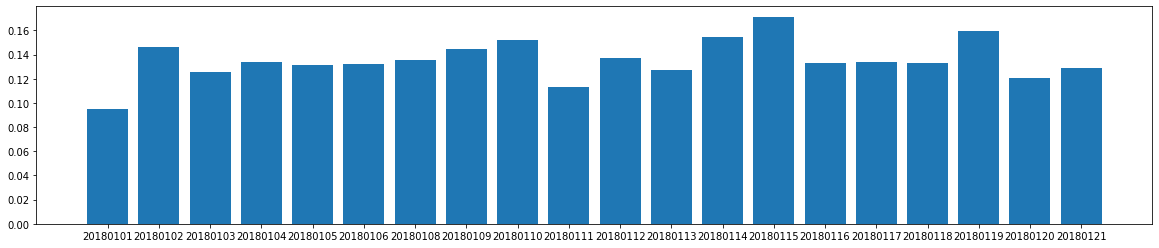

In [239]:
%matplotlib inline
import matplotlib.pyplot as plt
plot_data = list(zip(*topic_28[0:20]))
plt.figure(figsize=(20,4))
plt.bar([str(x) for x in list(plot_data[0])],list(plot_data[1]))
plt.show()

### Also we can exlore top topics using visualization tool pyLDAvis, show visualization for the date 2018-01-20:

In [136]:
# show topic distribution for documents for date (20170501) based on 20K sample
ldaVis = prepare_lda_vis_date_range('model/bow_corpus_20k.mm','model/bow_dict_20k.dic','model/lda_20k.model','db/news_lemma_20k.db',(20180120,20180120))
ldaVis

C:\Anaconda3\envs\topics\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Anaconda3\envs\topics\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Visualization is prepared ...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
28    -0.301436 -0.185775       1        1  17.250479
73    -0.257526 -0.096646       2        1  10.165198
61    -0.241189 -0.096202       3        1   9.341133
17    -0.269238 -0.131587       4        1   5.498528
99    -0.006548  0.070538       5        1   4.507221
...         ...       ...     ...      ...        ...
20     0.097046 -0.086220      96        1   0.022893
7      0.117075 -0.142638      97        1   0.017709
93     0.132352 -0.193519      98        1   0.009522
52     0.141066 -0.232643      99        1   0.005012
32     0.139720 -0.277987     100        1   0.002068

[100 rows x 5 columns], topic_info=      Category      Freq          Term     Total  loglift  logprob
2591   Default  8.000000      facebook  8.000000  30.0000  30.0000
914    Default  4.000000          city  4.000000  29.0000  29.0000
112    Default  5.000000        online  5.000000  28.0000  28.0000
2765   Default  5.000000  social_media  5.000000  27.0000  27.0000
3289   Default  4.000000      new_york  4.000000  26.0000  26.0000
...        ...       ...           ...       ...      ...      ...
115   Topic100  0.000002         place  1.224351  -2.5639  -9.4820
1169  Topic100  0.000002         cover  1.003623  -2.3855  -9.5024
1316  Topic100  0.000002          hold  1.239005  -2.5804  -9.4865
669   Topic100  0.000002          make  4.586177  -3.8546  -9.4520
281   Topic100  0.000002           add  2.491417  -3.3148  -9.5224

[4187 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
13504     18  1.925740  accident
3399       2  0.596353    accord
3399       3  0.596353    accord
1033       5  0.548490   account
5880       2  1.021122    accuse
...      ...       ...       ...
849        4  0.282798      work
187       12  0.986207     world
1028      19  1.070667     write
3628       3  0.782722      year
279        1  0.803058       yet

[340 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[29, 74, 62, 18, 100, 10, 37, 60, 79, 39, 73, 47, 43, 11, 87, 63, 12, 54, 97, 28, 90, 69, 22, 82, 23, 27, 17, 68, 1, 58, 24, 36, 20, 32, 86, 98, 81, 49, 7, 35, 66, 89, 42, 91, 99, 46, 34, 48, 88, 9, 13, 51, 25, 16, 95, 77, 71, 59, 83, 57, 76, 96, 78, 67, 40, 52, 93, 75, 64, 85, 26, 14, 31, 19, 2, 56, 3, 61, 72, 4, 65, 55, 30, 45, 5, 92, 84, 80, 44, 41, 50, 15, 38, 70, 6, 21, 8, 94, 53, 33])

## 5. Emergence of subtopics and topic evolution in time (DTM approach)

Due to luck of time I was not able to successfuly implement a model capable of showing topic evolution and appearece of subtopic.
One idea I had is to train a sequence of LDA models using a data up to specific incrementally increased date. Then one can correlate topics in each models using some similarity distance measure between texts (e.g. Jakkart measure). This approach is quite cumbersome and probably wont give reliable result. 
Much better option is to use Dynamic Topic Model where every topic had also a time dimension and allowed slightly change in time. The main paper describing it is by  Blei and Lafferty (https://mimno.infosci.cornell.edu/info6150/readings/dynamic_topic_models.pdf).  I have tried gensim python implementation using gensim.models.ldaseqmodel.LdaSeqModel. Since training is extremely slow (or for larger sets seems to be lucking memory) I was able only to train small chunk of dataset between dates 2018-01-01 and 2018-03-30 with 5 topics on 1K sub-sample. Below I load trained model (it was trained outside of notebook) and demonstrate function that allows to see time evolution of the topic. One example, that is shown below, demonstrates the evolution of the topic number 4. We can see that the original set of words representing this topic receives slight modifications as it evolves in time. For example the word "treatment" got mixed in on 2018-01-31 and later the word "hepatitis" got added in, indicating possible apperance of new subtopic related to illness. I did not have enough time to train bigger set and do proper analysis and interpretation of trained result. 

In [442]:
# Code used to train LdaSeqModel outside this notebook for 1K sample on time chunk between 2018-01-01 and 2018-03-30
#train_ldaseq_from_files(5, 'model/bow_corpus_1k.mm', 'model/bow_dict_1k.dic', 'db/news_lemma_1k.db',(20180101,20180330),\
#                        lda_file='model/lda_1k.model', to_save=True,model_file='model/ldaseq_1k.model', passes=5, initialize='ldamodel')

In [443]:
from gensim.models.ldaseqmodel import LdaSeqModel
ldaseq_1K = LdaSeqModel.load('model/ldaseq_1k.model')
date_seq = get_date_seq('db/news_lemma_1k.db', 20180101, 20180330)
topic_times = ldaseq_1K.print_topic_times(topic=4)
pprint(list(zip(date_seq,topic_times)))

[(20180101,
  [('state', 0.015271494818245553),
   ('mr', 0.012146570853406329),
   ('drug', 0.008618646383129236),
   ('include', 0.0069090240641194655),
   ('shooting', 0.006678657085533011),
   ('marijuana', 0.006543886355484383),
   ('investigation', 0.0059185168149620115),
   ('black', 0.005840463501697342),
   ('charge', 0.005199226886362729),
   ('explosion', 0.004864632041603249),
   ('consider', 0.004706245984580459),
   ('price', 0.004698723210867283),
   ('case', 0.004686897658448617),
   ('austin', 0.004503120210645233),
   ('inmate', 0.004452877114235688),
   ('man', 0.004426925983972152),
   ('race', 0.004330122402714204),
   ('bill', 0.0042729704867504594),
   ('seek', 0.004265813460889001),
   ('law', 0.004207331858138429)]),
 (20180104,
  [('state', 0.01532265743298625),
   ('mr', 0.012183090749965842),
   ('drug', 0.008640683311450936),
   ('include', 0.006923548528963465),
   ('shooting', 0.006693453039012781),
   ('marijuana', 0.006558338771911202),
   ('investigati

# 6. Sentiment analysis per topic

One approach to identify topic related sentiment within the text would to use the sentiment score for individual words that are present in the document and define aggregated sentiment using actual distribution of words in the document and distribution in the topic. Such approach may luck much of precision since it wont take into account the word interaction in the sentiment score (since like negation may be missed out). I did not have time to explore research literature in this field, so I just come up with some approach which seems to be reasonable. I split every document onto sentences, including title as first sentence. For every sentence I can calculate the sentiment score and topic distribution. Based on this information I can evaluate the sentiment for given topic based on the list of the sentences representing the article or the entire day. To do that I exclude all the low probability topics for every sentence distribution as well as sentences with neutral or near neutral score (capturing only strong sentiments, avoiding "averaging to neutral" effect). In the remaining calculated data I collect for every topic all the sentence sentiment scores with corresponding topic weight and use the latter set of topic weights w_s (for given sentence s) to compute the weighted average of scores using the normalized weights produced out of w_s: Wnorm_s = w_s/(sum(w_s). The latter weight allow to take into consideration the contribution strength of the sentence in the given topic. The function **calc_summary_sentiment_per_topic** does such averaging.
This approach is easy to apply to any set of sentences, which may represent on article or collection of articles aggregated by date, for example. Below I demonstrate the calculation for one article, as well as for one day, extracting the top topics and their relative sentiments.

## 6.1. Helper functions 

In [396]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim import corpora
from gensim.models import LdaModel
import functools
import operator

def split_on_sentences(text):
    phrase_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    return phrase_tokenizer.tokenize(text)

'''
    Extract sentences from cleaned source db for given row_id
     returns list of sentences
'''
def get_sentences_for_doc(source_db, rowid):
    sql = "select title ||'. '|| content from news where rowid = {}".format(rowid)
    row = get_single_value(source_db, sql)
    return split_on_sentences(row)

'''
    Extract sentences from cleaned source db for given date
     returns list of sentences
'''
def get_sentences_for_date(source_db, date):
    sql = "select title ||'. '|| content from news where date = {} order by rowid".format(date)
    list_of_lists = [split_on_sentences(doc) for doc in get_list(source_db, sql)]
    return list(reduce(operator.add,list_of_lists))

'''
    Calculates compound sentiment score for given input texts. 
    It is based on NLTK implementation using SentimentIntensityAnalyzer()
     returns float values of compound sentiment score
'''
def get_sentiment_score(text):
    return SentimentIntensityAnalyzer().polarity_scores(text)["compound"]

'''
    Create BOW representation for given non-tokenized text and word dictionary of type gensim.corpora.Dictionary
    returns BOW representation for the text in the format used in gensim library
'''
def build_bow_from(text, dictionary):
    tokens = tokenize(text)
    tokens = add_bigrams(tokens)
    return dictionary.doc2bow(tokens)

'''
    Calculate a list of tuples per every sentnce each containing distribution of top topics, sentiment score and sentence index in original input list
    Resulting list excludes the tuples for the sentences with near neutral sentiment (threshold abs(score) < min_score_abs) and low probabilities 
    (threshold < min_topic_prob )   topics are excluded from each distribution 
'''
def topics_sentiments_for_sentences(sentences, lda_model_file,dict_file, top_n, min_score_abs=0.1, min_topic_prob=0.1):
    sentiments = [get_sentiment_score(s) for s in sentences]
    topics = []
    bow_dict = corpora.Dictionary.load(dict_file)
    lda_model = LdaModel.load(lda_model_file)
    for sen in sentences:
        bow = build_bow_from(sen, bow_dict)
        topics.append(top_topics(lda_model, bow, top_n))
    res = enumerate(list(zip(sentiments,topics)))
    res = list(map(lambda x: x[1]+(x[0],),res))
    res = list(filter(lambda x: abs(x[0]) > min_score_abs, res))
    res = [(score, list(filter(lambda x: x[1] > min_topic_prob,topics)),id) for (score, topics,id) in res ]
    return list(filter(lambda x: len(x[1]) > 0, res))
 
'''
    Pivot a data structure computed by previous function by creating list of tuple per every topic, containing all scores 
    and sentences indeces for each topic
'''
def sentence_sentiment_per_topic(topics_sentiments):
    sentim_map = dict()
    for (score, topics, id) in topics_sentiments:
        for topic in topics:
            prev_data = sentim_map[topic[0]] if topic[0] in sentim_map else []
            sentim_map[topic[0]] = prev_data + [(id, score, topic[1])]   
    return sentim_map

'''
    Based on data structure outputed by previous function computed overall sentiment per topic for given collection of sentences
    The final sentiment score value is computed as weighted average sentence attributed values based on probabilities of given topic for given sentence 
'''
def calc_summary_sentiment_per_topic(sentence_topic_sentiments, show_indexes=True):
    sentim_map = dict()
    for topic_no, data in sentence_topic_sentiments.items():
        data_sum = list(map(lambda sent_data:(sent_data[1]*sent_data[2], sent_data[2],[sent_data[0]]), data))
        data_sum = list(reduce(lambda x,y:(x[0]+y[0],x[1]+y[1],x[2]+y[2]),data_sum,))
        if show_indexes:
            sentim_map[topic_no] = (data_sum[0]/data_sum[1], data_sum[2])
        else:
            sentim_map[topic_no] = data_sum[0]/data_sum[1]
    return sentim_map

'''
    Calculate a sentiment scores accumulated per topic with corresponding topic probabilities for given sentence basde on saved LDA model, 
    dictionary file. Input contains list of input sentences, number of top topics and filtering parameter for sentiment score and topic probability
'''
def build_sentence_sentiment_per_topic_from_source(sentences, lda_model_file,dict_file, top_n, min_score_abs=0.1, min_topic_prob=0.1):
    topics_sentiments_sent = topics_sentiments_for_sentences(sentences, lda_model_file,dict_file, top_n, \
                                                                        min_score_abs=min_score_abs, min_topic_prob=min_topic_prob)
    return sentence_sentiment_per_topic(topics_sentiments_sent)


## 6.2. Compute sentiment per topic

Below I show an sentiment per topic structure for the document no. 19220, keeping only 5 top topics and using default thresholds 

In [397]:
from pprint import pprint

sentence_sentiment_per_topic_str = build_sentence_sentiment_per_topic_from_source(get_sentences_for_doc('db/news_cleaned_20k.db',19220),'model/lda_20k.model','model/bow_dict_20k.dic',3)
pprint(sentence_sentiment_per_topic_str)

{17: [(16, 0.1779, 0.1125025),
      (27, 0.4588, 0.10271348),
      (39, 0.3612, 0.11005529),
      (40, 0.25, 0.11021522)],
 28: [(2, 0.4404, 0.13676205),
      (3, 0.4019, 0.14105134),
      (9, -0.34, 0.13742715),
      (11, -0.3182, 0.15795514),
      (13, 0.8724, 0.17897457),
      (15, 0.6908, 0.15616019),
      (16, 0.1779, 0.1353203),
      (17, -0.296, 0.15629424),
      (18, -0.7506, 0.17346957),
      (19, 0.1531, 0.13734536),
      (20, 0.128, 0.15185456),
      (22, -0.4767, 0.13832322),
      (24, -0.6908, 0.13433965),
      (26, 0.4364, 0.13716638),
      (27, 0.4588, 0.13196208),
      (28, -0.6249, 0.13910443),
      (32, -0.25, 0.13191833),
      (33, -0.8625, 0.12345644),
      (34, 0.4215, 0.13003807),
      (35, 0.5859, 0.12370769),
      (37, 0.3818, 0.12986879),
      (39, 0.3612, 0.12594995),
      (40, 0.25, 0.13985124),
      (41, -0.128, 0.13866739),
      (42, 0.5267, 0.12708591),
      (45, 0.9081, 0.16176796),
      (47, 0.3716, 0.12311518),
      (49, 0.

#### Calculate summarized sentiment for identified topics (17 and 28): both show positive sentiments of corresponding intensity 0.308 and 0.116

In [399]:
pprint(calc_summary_sentiment_per_topic(sentence_sentiment_per_topic_str, show_indexes=False))

{17: 0.3087234992029428, 28: 0.11606903863330632}


####  Do the same analysis for the date 2016-01-23 which contains above document 

In [401]:
sentence_sentiment_per_topic_str1 = build_sentence_sentiment_per_topic_from_source(get_sentences_for_date('db/news_cleaned_20k.db',20180123),'model/lda_20k.model','model/bow_dict_20k.dic',3)
pprint(sentence_sentiment_per_topic_str)

{17: [(16, 0.1779, 0.1125025),
      (27, 0.4588, 0.10271348),
      (39, 0.3612, 0.11005529),
      (40, 0.25, 0.11021522)],
 28: [(2, 0.4404, 0.13676205),
      (3, 0.4019, 0.14105134),
      (9, -0.34, 0.13742715),
      (11, -0.3182, 0.15795514),
      (13, 0.8724, 0.17897457),
      (15, 0.6908, 0.15616019),
      (16, 0.1779, 0.1353203),
      (17, -0.296, 0.15629424),
      (18, -0.7506, 0.17346957),
      (19, 0.1531, 0.13734536),
      (20, 0.128, 0.15185456),
      (22, -0.4767, 0.13832322),
      (24, -0.6908, 0.13433965),
      (26, 0.4364, 0.13716638),
      (27, 0.4588, 0.13196208),
      (28, -0.6249, 0.13910443),
      (32, -0.25, 0.13191833),
      (33, -0.8625, 0.12345644),
      (34, 0.4215, 0.13003807),
      (35, 0.5859, 0.12370769),
      (37, 0.3818, 0.12986879),
      (39, 0.3612, 0.12594995),
      (40, 0.25, 0.13985124),
      (41, -0.128, 0.13866739),
      (42, 0.5267, 0.12708591),
      (45, 0.9081, 0.16176796),
      (47, 0.3716, 0.12311518),
      (49, 0.

In [402]:
pprint(calc_summary_sentiment_per_topic(sentence_sentiment_per_topic_str1, show_indexes=False))

{17: -0.09713622474286991, 28: -0.15667838534887796}


We see that daily overall sentiment for the topic 17 and 28 are slightly negative, although close to neutral

# 7. Further considerations

Very promising approach to TM  in deep learning space is lda2vec, extension of word2vec embedding where the neural network learns embedding vectors for words, topics and documents simultanuasely. The composition of topics in the document and words in the topic can be easily recovered via distance measure in embedded space. The big advantage is that by using pretrained embedding layer with semantic context knowledge we can incorporate semantic context in similarity measures between words and topics. Training lda2vec requires GPU and not easy to make it converge, thus this will remain the topic of my future study.